## Assignment 01. Simple text processing.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from IPython import display
plt.style.use('ggplot')

### Toxic or not
Your main goal in this assignment is to classify, whether the comments are toxic or not. And practice with both classical approaches and PyTorch in the process.

*Credits: This homework is inspired by YSDA NLP_course.*

In [2]:
# In colab run this cell
! wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/advanced_f20/homeworks_advanced/assignment1_01_Word_Vectors/utils.py -nc

File ‘utils.py’ already there; not retrieving.



In [3]:
try:
    data = pd.read_csv('../../datasets/comments_small_dataset/comments.tsv', sep='\t')
except FileNotFoundError:
    ! wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/advanced_f20/datasets/comments_small_dataset/comments.tsv -nc
    data = pd.read_csv("comments.tsv", sep='\t')

File ‘comments.tsv’ already there; not retrieving.



In [4]:
texts = data['comment_text'].values
target = data['should_ban'].values
data[50::200]

,should_ban,comment_text
50,0,"""Those who're in advantageous positions are th..."
250,1,Fartsalot56 says f**k you motherclucker!!
450,1,"Are you a fool? \n\nI am sorry, but you seem t..."
650,1,I AM NOT A VANDAL!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
850,0,Citing sources\n\nCheck out the Wikipedia:Citi...


In [5]:
from sklearn.model_selection import train_test_split
texts_train, texts_test, y_train, y_test = train_test_split(texts, target, test_size=0.5, random_state=42)

__Note:__ it is generally a good idea to split data into train/test before anything is done to them.

It guards you against possible data leakage in the preprocessing stage. For example, should you decide to select words present in obscene tweets as features, you should only count those words over the training set. Otherwise your algoritm can cheat evaluation.

### Preprocessing and tokenization

Comments contain raw text with punctuation, upper/lowercase letters and even newline symbols.

To simplify all further steps, we'll split text into space-separated tokens using one of nltk tokenizers.

Generally, library `nltk` [link](https://www.nltk.org) is widely used in NLP. It is not necessary in here, but mentioned to intoduce it to you.

In [6]:
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer()
preprocess = lambda text: ' '.join(tokenizer.tokenize(text.lower()))

text = 'How to be a grown-up at work: replace "I don\'t want to do that" with "Ok, great!".'
print("before:", text,)
print("after:", preprocess(text),)

before: How to be a grown-up at work: replace "I don't want to do that" with "Ok, great!".
after: how to be a grown-up at work : replace " i don't want to do that " with " ok , great ! " .


In [7]:
# task: preprocess each comment in train and test

texts_train = [preprocess(text) for text in texts_train]
texts_test = [preprocess(text) for text in texts_test]

In [8]:
# Small check that everything is done properly
assert texts_train[5] ==  'who cares anymore . they attack with impunity .'
assert texts_test[89] == 'hey todds ! quick q ? why are you so gay'
assert len(texts_test) == len(y_test)

### Step 1: bag of words

One traditional approach to such problem is to use bag of words features:
1. build a vocabulary of frequent words (use train data only)
2. for each training sample, count the number of times a word occurs in it (for each word in vocabulary).
3. consider this count a feature for some classifier

__Note:__ in practice, you can compute such features using sklearn. __Please don't do that in the current assignment, though.__
* `from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer`

In [9]:
# task: find up to k most frequent tokens in texts_train,
# sort them by number of occurences (highest first)
from collections import Counter
k = min(10000, len(set(' '.join(texts_train).split())))

token_counts = Counter()
for text in texts_train:
    token_counts.update(text.split())

bow_vocabulary = [pair[0] for pair in token_counts.most_common(k)]

print('example features:', sorted(bow_vocabulary)[::100])

example features: ['!', '12:20', '300', '_', 'adorned', 'alternative', 'archive', 'average', 'benkner', 'bout', 'came', 'chest', 'combined', 'consumers', 'cricket', 'decisions', 'dickheads', 'domestic', 'eductaion', 'essentially', 'faggot', 'firms', 'frustrated', 'goal', 'hanibal', 'hip-hop', 'identified', 'infoboxes', 'issue', 'kindergarten', 'lets', 'lot', "mclaren's", 'moderator', 'naturally', 'noticeable', 'opposing', 'pdf', 'plant', 'pretoria', 'punctuation', 'rebels', 'repetative', 'riadh', 'schulz', 'shes', 'slit', 'spoof', 'stupid', 't', 'theoretical', 'topic', 'uglyness', 'userspace', 'wanted', 'wikieditor', 'year', 'ீ']


In [10]:
def text_to_bow(text):
    """ convert text string to an array of token counts. Use bow_vocabulary. """
    words_dict = {word: 0 for word in bow_vocabulary}
    
    for word in text.split():
        if word in words_dict.keys():
            words_dict[word] += 1
    
    return np.array(list(words_dict.values()), 'float32')

In [11]:
X_train_bow = np.stack(list(map(text_to_bow, texts_train)))
X_test_bow = np.stack(list(map(text_to_bow, texts_test)))

In [12]:
# Small check that everything is done properly
k_max = len(set(' '.join(texts_train).split()))
assert X_train_bow.shape == (len(texts_train), min(k, k_max))
assert X_test_bow.shape == (len(texts_test), min(k, k_max))
assert np.all(X_train_bow[5:10].sum(-1) == np.array([len(s.split()) for s in  texts_train[5:10]]))
assert len(bow_vocabulary) <= min(k, k_max)
assert X_train_bow[6, bow_vocabulary.index('.')] == texts_train[6].split().count('.')

Now let's do the trick with `sklearn` logistic regression implementation:

In [13]:
from sklearn.linear_model import LogisticRegression
bow_model = LogisticRegression().fit(X_train_bow, y_train)

In [61]:
from sklearn.metrics import roc_auc_score, roc_curve

def plot_roc_curve(clf_model, X_train, X_test, y_train, y_test):
    for name, X, y, model in [
        ('train', X_train, y_train, clf_model),
        ('test ', X_test, y_test, clf_model)
    ]:
        proba = model.predict_proba(X)[:, 1]
        auc = roc_auc_score(y, proba)
        plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

    plt.plot([0, 1], [0, 1], '--', color='black',)
    plt.legend(fontsize='large')

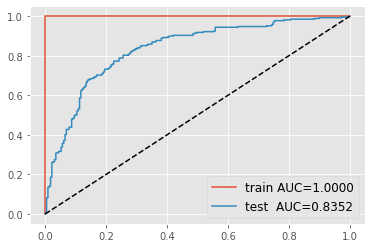

In [62]:
plot_roc_curve(bow_model, X_train_bow, X_test_bow, y_train, y_test)

Seems alright. Now let's create the simple logistic regression using PyTorch. Just like in the classwork.

In [16]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

from sklearn.metrics import accuracy_score

In [17]:
from utils import plot_train_process

In [18]:
nn_bow_model = nn.Sequential()

nn_bow_model.add_module('linear', nn.Linear(in_features=k, out_features=2))

Remember what we discussed about loss functions! `nn.CrossEntropyLoss` combines both log-softmax and `NLLLoss`.

__Be careful with it! Criterion `nn.CrossEntropyLoss` with still work with log-softmax output, but it won't allow you to converge to the optimum.__ Next comes small demonstration:

In [19]:
# loss_function = nn.NLLLoss()
loss_function = nn.CrossEntropyLoss()

In [20]:
opt = torch.optim.Adam(nn_bow_model.parameters())

In [21]:
lr_scheduler = ReduceLROnPlateau(optimizer=opt)

In [22]:
X_train_bow_torch = torch.tensor(X_train_bow)
X_test_bow_torch = torch.tensor(X_test_bow)

y_train_torch = torch.tensor(y_train)
y_test_torch = torch.tensor(y_test)

Let's test that everything is fine

In [23]:
# example loss
loss = loss_function(nn_bow_model(X_train_bow_torch[:3]), y_train_torch[:3])

In [24]:
assert type(loss.item()) == float

Here comes small function to train the model. In future we will take in into separate file, but for this homework it's ok to implement it here. 

In [25]:
def train_model(
    model,
    opt,
    lr_scheduler,
    X_train_torch,
    y_train_torch,
    X_val_torch,
    y_val_torch,
    n_iterations=500,
    batch_size=32,
    warm_start=False,
    show_plots=True,
    eval_every=10
):
    if not warm_start:
        for name, module in model.named_children():
            print('resetting ', name)
            try:
                module.reset_parameters()
            except AttributeError as e:
                print('Cannot reset {} module parameters: {}'.format(name, e))

    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    local_train_loss_history = []
    local_train_acc_history = []
    for i in range(n_iterations):

        # sample 256 random observations
        ix = np.random.randint(0, len(X_train_torch), batch_size)
        x_batch = X_train_torch[ix]
        y_batch = y_train_torch[ix]

        # predict log-probabilities or logits
        y_predicted = model(x_batch)

        # compute loss, just like before
        loss = loss_function(y_predicted, y_batch)

        # compute gradients
        loss.backward()

        # Adam step
        opt.step()

        # clear gradients
        opt.zero_grad()


        local_train_loss_history.append(loss.data.numpy())
        local_train_acc_history.append(
            accuracy_score(
                y_batch.to('cpu').detach().numpy(),
                y_predicted.to('cpu').detach().numpy().argmax(axis=1)
            )
        )

        if i % eval_every == 0:
            train_loss_history.append(np.mean(local_train_loss_history))
            train_acc_history.append(np.mean(local_train_acc_history))
            local_train_loss_history, local_train_acc_history = [], []

            predictions_val = model(X_val_torch)
            val_loss_history.append(loss_function(predictions_val, y_val_torch).to('cpu').detach().item())

            acc_score_val = accuracy_score(y_val_torch.cpu().numpy(), predictions_val.to('cpu').detach().numpy().argmax(axis=1))
            val_acc_history.append(acc_score_val)
            lr_scheduler.step(train_loss_history[-1])

            if show_plots:
                display.clear_output(wait=True)
                plot_train_process(train_loss_history, val_loss_history, train_acc_history, val_acc_history)

    if show_plots:
        return model
    else:            
        return train_loss_history, val_loss_history, train_acc_history, val_acc_history

Let's run it on the data. Note, that here we use the `test` part of the data for validation. It's not so good idea in general, but in this task our main goal is practice.

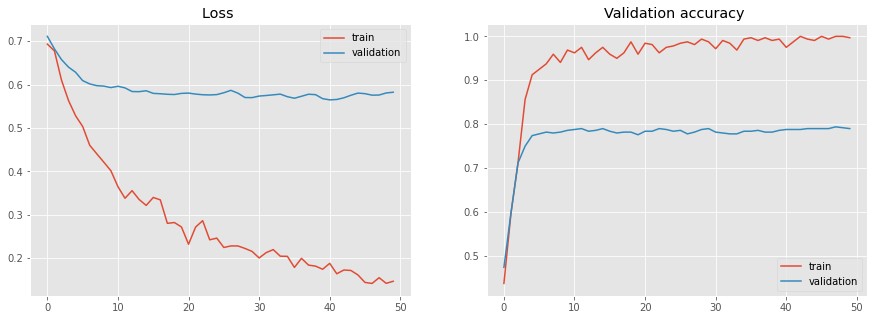

Sequential(
  (linear): Linear(in_features=5722, out_features=2, bias=True)
)

In [26]:
train_model(nn_bow_model, opt, lr_scheduler, X_train_bow_torch, y_train_torch, X_test_bow_torch, y_test_torch)

Try to vary the number of tokens `k` and check how the model performance changes. Show it on a plot.

In [27]:
k = min(10000, len(set(' '.join(texts_train).split())))
# divisors = [2.0, 1.9, 1.8, 1.7, 1.6, 1.5, 1.4, 1.3, 1.2, 1.1, 1]
divisors = [3.0, 2.5, 2.0, 1.5, 1.]
num_of_tokens = [int(k / divisor) for divisor in divisors]

token_counts = Counter()
for text in texts_train:
    token_counts.update(text.split())

In [28]:
train_loss_history, val_loss_history, train_acc_history, val_acc_history = [], [], [], []

for num in num_of_tokens:
    bow_vocabulary = [pair[0] for pair in token_counts.most_common(num)]

    X_train_bow = np.stack(list(map(text_to_bow, texts_train)))
    X_test_bow = np.stack(list(map(text_to_bow, texts_test)))
    X_train_bow_torch = torch.tensor(X_train_bow)
    X_test_bow_torch = torch.tensor(X_test_bow)
    y_train_torch = torch.tensor(y_train)
    y_test_torch = torch.tensor(y_test)


    nn_bow_model = nn.Sequential()
    nn_bow_model.add_module('linear', nn.Linear(in_features=num, out_features=2))
    loss_function = nn.CrossEntropyLoss()
    opt = torch.optim.Adam(nn_bow_model.parameters())
    lr_scheduler = ReduceLROnPlateau(optimizer=opt)

    train_loss, val_loss, train_acc, val_acc = train_model(nn_bow_model,
                                                           opt,
                                                           lr_scheduler,
                                                           X_train_bow_torch,
                                                           y_train_torch,
                                                           X_test_bow_torch,
                                                           y_test_torch,
                                                           show_plots=False)
    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    train_acc_history.append(train_acc)
    val_acc_history.append(val_acc)

resetting  linear
resetting  linear
resetting  linear
resetting  linear
resetting  linear


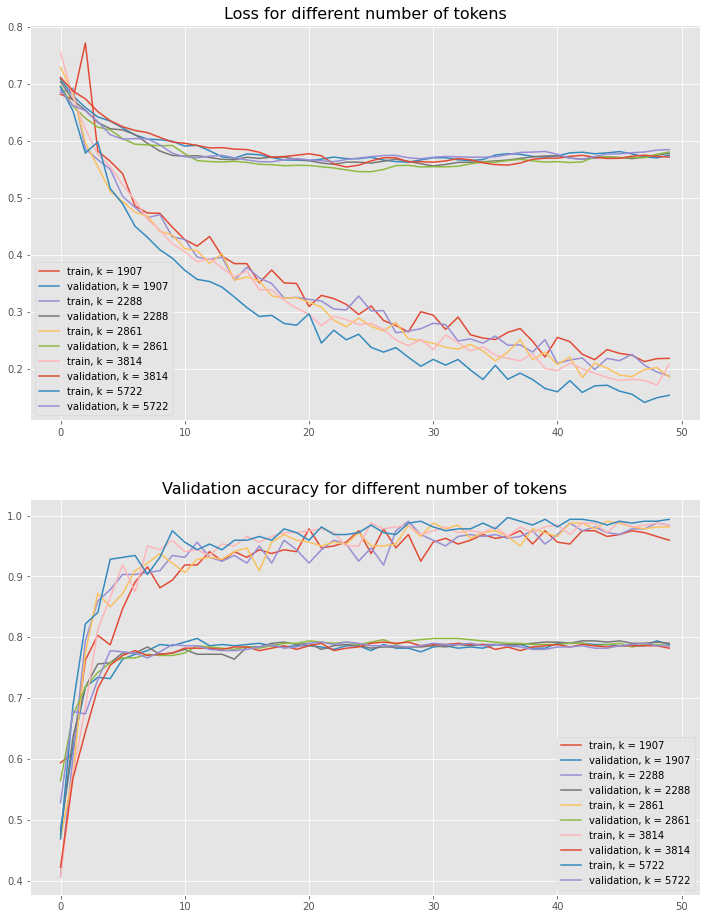

In [30]:
plt.figure(figsize=(12, 16))

plt.subplot(2, 1, 1)
plt.title('Loss for different number of tokens', fontsize=16)
for i, num_tokens in enumerate(num_of_tokens):
    plt.plot(train_loss_history[i], label='train, k = {}'.format(num_tokens))
    plt.plot(val_loss_history[i], label='validation, k = {}'.format(num_tokens))
    plt.legend()

plt.subplot(2, 1, 2)
plt.title('Validation accuracy for different number of tokens', fontsize=16)
for i, num_tokens in enumerate(num_of_tokens):
    plt.plot(train_acc_history[i], label='train, k = {}'.format(num_tokens))
    plt.plot(val_acc_history[i], label='validation, k = {}'.format(num_tokens))
    plt.legend()

plt.show()

The scores do not vary so much, however, it looks like the more tokens are in the `bow_vocabulary` the better scores it is possible to achieve.

### Step 2: implement TF-IDF features

Not all words are equally useful. One can prioritize rare words and downscale words like "and"/"or" by using __tf-idf features__. This abbreviation stands for __text frequency/inverse document frequence__ and means exactly that:

$$ feature_i = { Count(word_i \in x) \times { log {N \over Count(word_i \in D) + \alpha} }}, $$


where x is a single text, D is your dataset (a collection of texts), N is a total number of documents and $\alpha$ is a smoothing hyperparameter (typically 1). 
And $Count(word_i \in D)$ is the number of documents where $word_i$ appears.

It may also be a good idea to normalize each data sample after computing tf-idf features.

__Your task:__ implement tf-idf features, train a model and evaluate ROC curve. Compare it with basic BagOfWords model from above.

__Please don't use sklearn/nltk builtin tf-idf vectorizers in your solution :)__ You can still use 'em for debugging though.

Blog post about implementing the TF-IDF features from scratch: https://triton.ml/blog/tf-idf-from-scratch

In [31]:
def make_tf_dict(text):
    tf_dict = {}

    for word in text.split():
        if word in tf_dict:
            tf_dict[word] += 1
        else:
            tf_dict[word] = 1
    
    for word in tf_dict:
        tf_dict[word] = tf_dict[word] / len(text.split())
        
    return tf_dict

In [32]:
tf_dicts = [make_tf_dict(text) for text in texts_train]

In [33]:
def make_doc_count_dict(tf_dicts):
    count_dict = {}

    for text in tf_dicts:
        for word in text:
            if word in count_dict:
                count_dict[word] += 1
            else:
                count_dict[word] = 1

    return count_dict

In [34]:
count_dict = make_doc_count_dict(tf_dicts)

In [35]:
def make_idf_dict(dataset, count_dict, alpha=1.):
    idf_dict = {}

    for word in count_dict:
        idf_dict[word] = np.log(len(dataset) / (count_dict[word] + alpha))
    
    return idf_dict

In [36]:
idf_dict = make_idf_dict(texts_train, count_dict)

In [37]:
def make_tf_idf_dict(tf_dict_text, idf_dict, bow_vocabulary):
    tf_idf_dict = {}

    for word in tf_dict_text:
        if word in bow_vocabulary:
            tf_idf_dict[word] = tf_dict_text[word] * idf_dict[word]

    return tf_idf_dict

In [38]:
tf_idf_dicts = [make_tf_idf_dict(text, idf_dict, bow_vocabulary) for text in tf_dicts]

In [39]:
def make_tf_idf_vector(text_tf_idf_dict, bow_vocabulary):
    tf_idf_vec = [0.] * len(bow_vocabulary)

    for index, word in enumerate(bow_vocabulary):
        if word in text_tf_idf_dict:
            tf_idf_vec[index] = text_tf_idf_dict[word]
    
    return tf_idf_vec

In [40]:
X_train_tfidf = np.array([make_tf_idf_vector(text_tf_idf, bow_vocabulary) for text_tf_idf in tf_idf_dicts], 'float32')

In [41]:
tf_dicts_test = [make_tf_dict(text) for text in texts_test]
tf_idf_dicts_test = [make_tf_idf_dict(text, idf_dict, bow_vocabulary) for text in tf_dicts_test]
X_test_tfidf = np.array([make_tf_idf_vector(text_tf_idf, bow_vocabulary) for text_tf_idf in tf_idf_dicts_test], 'float32')

Let's do the same procedure with TF-IDF vectors as with BOW model.

In [65]:
tfidf_model = LogisticRegression().fit(X_train_tfidf, y_train)

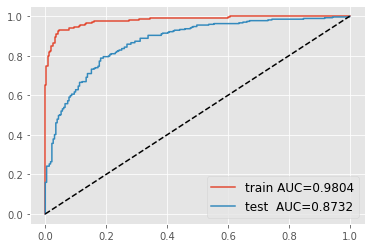

In [66]:
plot_roc_curve(tfidf_model, X_train_tfidf, X_test_tfidf, y_train, y_test)

Same stuff about model and optimizers here (or just omit it, if you are using the same model as before).

In [42]:
model_tfidf = nn.Sequential()

model_tfidf.add_module('linear', nn.Linear(in_features=k, out_features=2))

In [43]:
opt = torch.optim.Adam(model_tfidf.parameters())

In [44]:
lr_scheduler = ReduceLROnPlateau(optimizer=opt)

In [45]:
X_train_tfidf_torch = torch.tensor(X_train_tfidf)
X_test_tfidf_torch = torch.tensor(X_test_tfidf)

y_train_torch = torch.tensor(y_train)
y_test_torch = torch.tensor(y_test)

Fit your model to the data. Do not hesitate to vary number of iterations, learning rate and so on.

_Note: due to very small dataset, increasing the complexity of the network might not be the best idea._

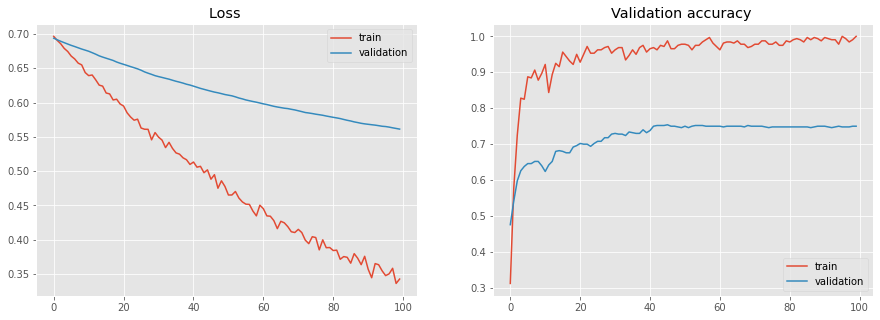

Sequential(
  (linear): Linear(in_features=5722, out_features=2, bias=True)
)

In [46]:
train_model(model_tfidf, opt, lr_scheduler, X_train_tfidf_torch, y_train_torch, X_test_tfidf_torch, y_test_torch, n_iterations=1000)

### Step 3: Comparing it with Naive Bayes

Naive Bayes classifier is a good choice for such small problems. Try to tune it for both BOW and TF-iDF features. Compare the results with Logistic Regression.

In [47]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB

In [48]:
nb_bow = MultinomialNB().fit(X_train_bow, y_train)
nb_tfidf = MultinomialNB().fit(X_train_tfidf, y_train)

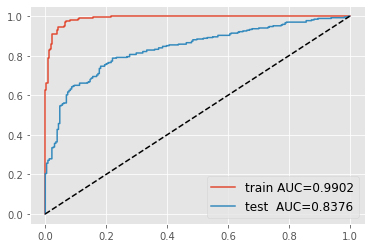

In [63]:
plot_roc_curve(nb_bow, X_train_bow, X_test_bow, y_train, y_test)

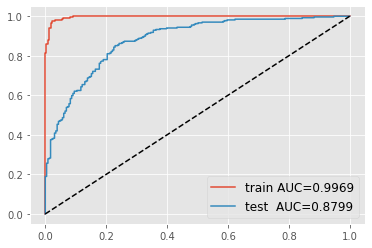

In [64]:
plot_roc_curve(nb_tfidf, X_train_tfidf, X_test_tfidf, y_train, y_test)

Shape some thoughts on the results you aquired. Which model has show the best performance? Did changing the learning rate/lr scheduler help?

It looks like the `MultinomialNB` model slightly outperformed Logistic Regression both for BOW and TF-IDF features. TF-IDF representation showed better results in terms of AUC score on the test data.

### Step 4: Using the external knowledge.

Use the `gensim` word2vec pretrained model to translate words into vectors. Use several models with this new encoding technique. Compare the results, share your thoughts.

In [51]:
from gensim.models.word2vec import Word2Vec
import gensim.downloader as api

In [81]:
w2v_model = api.load('word2vec-google-news-300')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:252: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Let's remove punctuation from the texts in order to feed it to word2vec model.

In [53]:
from nltk.tokenize import RegexpTokenizer

regexp_tokenizer = RegexpTokenizer(r'\w+')

In [54]:
texts_train_w2v = []
texts_test_w2v = []

for i in range(len(texts_train)):
    texts_train_w2v.append(regexp_tokenizer.tokenize(texts_train[i]))

for i in range(len(texts_test)):
    texts_test_w2v.append(regexp_tokenizer.tokenize(texts_test[i]))

To get the embeddings of the whole sentence we will average consisting word embeddings of it.

In [55]:
def get_sentence_embedding(sentence):
    word_embeddings = []

    for word in sentence:
        word_embeddings.append(w2v_model[word] if word in w2v_model.vocab else w2v_model['UNK'])

    return np.mean(word_embeddings, axis=0)

In [69]:
X_train_w2v = np.stack(list(map(get_sentence_embedding, texts_train_w2v)))
X_test_w2v = np.stack(list(map(get_sentence_embedding, texts_test_w2v)))

X_train_w2v_torch = torch.tensor(X_train_w2v)
X_test_w2v_torch = torch.tensor(X_test_w2v)

Let's use `LogisticRegression` from `sklearn`.

In [75]:
model_w2v_log_reg = LogisticRegression().fit(X_train_w2v, y_train)

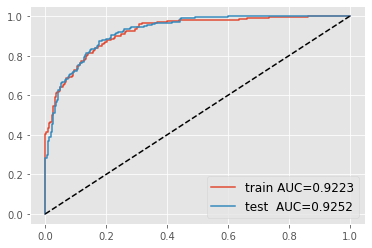

In [76]:
plot_roc_curve(model_w2v_log_reg, X_train_w2v, X_test_w2v, y_train, y_test)

Let's apply logistic regression in PyTorch.

In [82]:
model_w2v = nn.Sequential()

model_w2v.add_module('linear', nn.Linear(in_features=w2v_model.vector_size, out_features=2))

loss_function = nn.CrossEntropyLoss()
opt_w2v = torch.optim.Adam(model_w2v.parameters())
lr_scheduler_w2v = ReduceLROnPlateau(optimizer=opt_w2v)

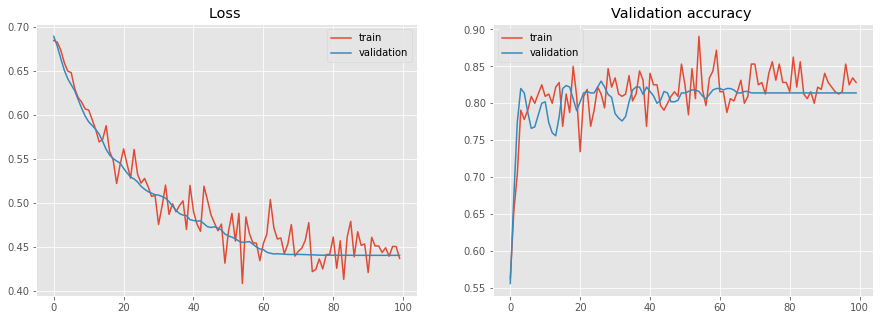

Sequential(
  (linear): Linear(in_features=300, out_features=2, bias=True)
)

In [83]:
train_model(model_w2v, opt_w2v, lr_scheduler_w2v, X_train_w2v_torch, y_train_torch, X_test_w2v_torch, y_test_torch, n_iterations=1000)

It looks like models achieve better perfomance with pretrained word2vec embeddings. It is not really surprising, because these embeddings were obtained by learning on Google News corpus (the word2vec model with 3 million 300-dimension English word vectors), while we had only 500 comments in our train part on data. 